In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import FDTDIResponseGenerator
from Triangle_BBH.Utils import Likelihood, Fstatistics
from Triangle_BBH.Fisher import *

import multiprocessing
if __name__=='__main__':
    multiprocessing.set_start_method("fork")

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 
no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform


## Data settings 

In [2]:
t_start = 200. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(21601,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_CPU = np.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((20732,), (20732,))

## Set response model 

In [4]:
# the path of Taiji orbit 
# orbit_CPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") 
orbit_CPU = Orbit(OrbitDir="/Users/taijidatacenter/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB")

# initialize  waveform generator 
WFG_CPU = WaveformGenerator(
    mode="primary", 
    # mode="full", 
)

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(
    orbit_class=orbit_CPU, 
    waveform_generator=WFG_CPU, 
)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2, 2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    tc_at_constellation=True, # whether tc is the coalescence time at constellation center (True) or SSB (False)
    TDIGeneration='2nd',
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
)

## Source parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start + 0.75 * Tobs) / DAY, (t_end - 0.1 * Tobs) / DAY] # ensure the inclusion of long enough GW waveform 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 2.03750000e+02,  2.04500000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

In [6]:
intrinsic_param_priors[4]

array([203.75, 204.5 ])

## Noise model 

In [7]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
print(arm_time/DAY)
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_CPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

204.125


((3, 20732), (20732, 3, 3))

## Data simulation 

In [8]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = np.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 336153.0258942781
mass_ratio : 0.9215125089056354
spin_1z : -0.4826983826704671
spin_2z : -0.05933385727558438
coalescence_time : 204.32100122901946
coalescence_phase : 2.804720860794819
luminosity_distance : 28695.030676092756
inclination : 1.4487716314627304
longitude : 1.1054049011232072
latitude : 0.4589791156736616
psi : 2.397999075284784
optimal SNR: 782.3787223824324


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

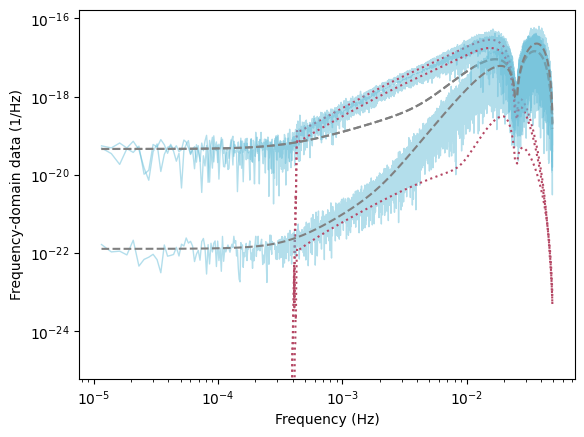

In [9]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel]), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel]), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [10]:
Fstat = Fstatistics(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
    use_gpu=False
)

### test waveform and parameter recovery

In [11]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 336153.0258942781,
 'mass_ratio': 0.9215125089056354,
 'spin_1z': -0.4826983826704671,
 'spin_2z': -0.05933385727558438,
 'coalescence_time': 204.32100122901946,
 'longitude': 1.1054049011232072,
 'latitude': 0.4589791156736616}

In [12]:
rec_a = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
# print(rec_a.shape)

rec_ext_params = Fstat.a_to_extrinsic(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | true value | difference")
for k, v in rec_ext_params.items():
    print(k, ":", mbhb_parameters[k], v-mbhb_parameters[k])

parameter name | true value | difference
luminosity_distance : 28695.030676092756 -46.3067700195752
inclination : 1.4487716314627304 0.0008612555450766557
psi : 2.397999075284784 -0.0011241854826913311
coalescence_phase : 2.804720860794819 -0.00011111345509373649


In [13]:
rec_params
rec_wave1 = FDTDI_CPU.Response(
    rec_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

rec_wave2 = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave1.shape, rec_wave2.shape 

((3, 20732), (3, 20732))

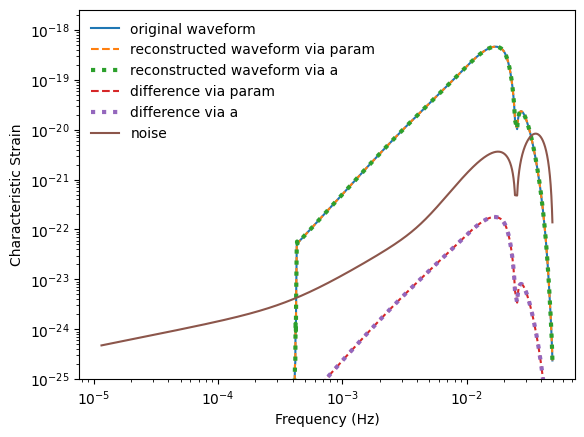

In [14]:
plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0]) * data_frequencies, linestyle="--", label="reconstructed waveform via param")
plt.loglog(data_frequencies, np.abs(rec_wave2[0]) * data_frequencies, linestyle=":", label="reconstructed waveform via a", linewidth=3)
plt.loglog(data_frequencies, np.abs(rec_wave1[0] - wf_channels[0]) * data_frequencies, label="difference via param", linestyle="--")
plt.loglog(data_frequencies, np.abs(rec_wave2[0] - wf_channels[0]) * data_frequencies, label="difference via a", linestyle=":", linewidth=3)
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [15]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
    return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-8,
    atol=1e-10,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    # vectorized=True,
    workers=-1, 
)

/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/

In [16]:
print(DE_result)

             message: Optimization terminated successfully.
             success: True
                 fun: -306663.2739745484
                   x: [ 2.648e-02  9.737e-01  1.267e-02  6.824e-01
                        7.613e-01  8.909e-01  3.003e-01]
                 nit: 340
                nfev: 167138
          population: [[ 2.648e-02  9.737e-01 ...  8.909e-01  3.003e-01]
                       [ 2.648e-02  9.737e-01 ...  8.908e-01  3.009e-01]
                       ...
                       [ 2.648e-02  9.738e-01 ...  8.909e-01  3.006e-01]
                       [ 2.648e-02  9.740e-01 ...  8.909e-01  3.000e-01]]
 population_energies: [-3.067e+05 -3.067e+05 ... -3.067e+05 -3.067e+05]
                 jac: [ 1.202e+02 -1.200e+01 -4.208e+00 -2.137e+01
                        1.374e+04  5.797e+00  1.162e+01]


### reconstruct parameters and waveforms 

In [17]:
from copy import deepcopy

# get all params 
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])
searched_a = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)
searched_params = dict(searched_int_params, **searched_ext_params)
# print("init search:")
# print(searched_params)

# # reconstruct waveform 
# searched_wf = Fstat.calculate_Fstat(
#     intrinsic_parameters=searched_int_params, 
#     return_recovered_wave=True
# ) # (3, Nfreq)

# # refine psi and phase 
# matched_flag = False 
# for psi_offset in [0., PI/2]:
#     for phi_offset in [0., PI/2.]:
#         rec_params_try = deepcopy(searched_params)
#         rec_params_try["psi"] = (rec_params_try["psi"] + psi_offset)%PI
#         rec_params_try["coalescence_phase"] = (rec_params_try["coalescence_phase"] + phi_offset)%TWOPI 
#         rec_wf_try = FDTDI_CPU.Response(
#             rec_params_try,
#             data_frequencies_CPU, 
#             **response_kwargs_CPU, 
#         )
#         res_snr_tmp = FrequencyDomainCovarianceSNR(rec_wf_try-searched_wf, InvCovMat)
#         if res_snr_tmp < 1.: 
#             print("best fit snr:", res_snr_tmp)
#             matched_flag = True 
#             searched_params = rec_params_try
#             break
#     if matched_flag:
#         break 

# get reflected params 
lon_ssb = searched_params["longitude"]
lat_ssb = searched_params["latitude"]
psi_ssb = searched_params["psi"]
lon_det, lat_det, psi_det = SSBPosToDetectorFrame(lon_ssb, lat_ssb, psi_ssb, searched_params["coalescence_time"]*DAY, orbit_CPU)
lat_det = -lat_det # reflect latitutde 
psi_det = PI - psi_det # reflect psi 
searched_ref_params = deepcopy(searched_params)
searched_ref_params["longitude"], searched_ref_params["latitude"], searched_ref_params["psi"] = DetectorPosToSSBFrame(lon_det, lat_det, psi_det, searched_params["coalescence_time"]*DAY, orbit_CPU)
searched_ref_params["inclination"] = PI - searched_params["inclination"] # reflect inclination 

print("parameter name | true value | searched value | searched value (reflection)")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], v, searched_ref_params[k])

parameter name | true value | searched value | searched value (reflection)
chirp_mass 336153.0258942781 336107.40566516324 336107.40566516324
mass_ratio 0.9215125089056354 0.9763281758381888 0.9763281758381888
spin_1z -0.4826983826704671 -0.8772018285113091 -0.8772018285113091
spin_2z -0.05933385727558438 0.3282407023836226 0.3282407023836226
coalescence_time 204.32100122901946 204.32099943929558 204.32099943929558
longitude 1.1054049011232072 5.597564145039376 1.095822211089041
latitude 0.4589791156736616 -0.41076199809660496 0.4314661446972389
luminosity_distance 28695.030676092756 28317.770045966365 28317.770045966365
inclination 1.4487716314627304 1.692966163636359 1.448626489953434
psi 2.397999075284784 0.10302782648441167 2.3999227309281435
coalescence_phase 2.804720860794819 2.81845503767693 2.81845503767693


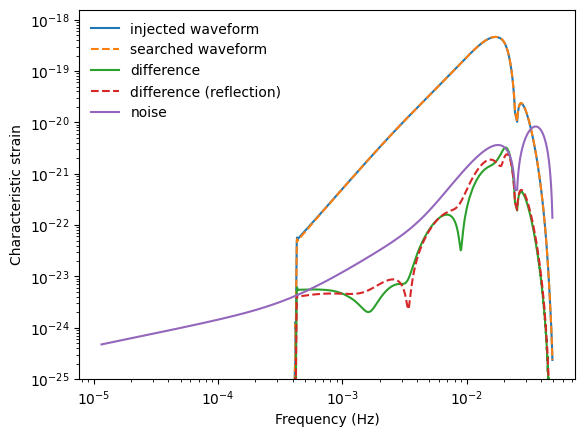

In [18]:
searched_wf1 = FDTDI_CPU.Response(
    searched_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

searched_wf2 = FDTDI_CPU.Response(
    searched_ref_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0]) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference")
plt.loglog(data_frequencies, np.abs(searched_wf2[0] - wf_channels[0]) * data_frequencies, linestyle="--", label="difference (reflection)")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [19]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_CPU.Response(
        parameters=param_dict, 
        freqs=np.array(frequencies),  
        **response_kwargs_CPU, 
    )
    return res

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    # param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 26.93174678483168,
 'mass_ratio': 0.024232476215024626,
 'spin_1z': 0.05221026084173724,
 'spin_2z': 0.05279865596191316,
 'coalescence_time': 2.5715975489395553e-06,
 'coalescence_phase': 0.01060240746134784,
 'luminosity_distance': 640.0031563051417,
 'inclination': 0.0014184776392099192,
 'longitude': 0.05032197278284394,
 'latitude': 0.06539037372999908,
 'psi': 0.04284060918468171}

In [20]:
print("parameter name | difference | difference (ref) | FIM bound")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), np.abs(searched_ref_params[k] - mbhb_parameters[k]), FIM.param_errors[k])

parameter name | difference | difference (ref) | FIM bound
chirp_mass 45.62022911483655 45.62022911483655 26.93174678483168
mass_ratio 0.05481566693255335 0.05481566693255335 0.024232476215024626
spin_1z 0.394503445840842 0.394503445840842 0.05221026084173724
spin_2z 0.38757455965920695 0.38757455965920695 0.05279865596191316
coalescence_time 1.7897238819841732e-06 1.7897238819841732e-06 2.5715975489395553e-06
longitude 4.492159243916169 0.00958269003416623 0.05032197278284394
latitude 0.8697411137702666 0.027512970976422746 0.06539037372999908
luminosity_distance 377.26063012639133 377.26063012639133 640.0031563051417
inclination 0.24419453217362874 0.00014514150929634262 0.0014184776392099192
psi 2.2949712488003726 0.0019236556433592789 0.04284060918468171
coalescence_phase 0.013734176882111093 0.013734176882111093 0.01060240746134784


## Test across population 

In [ ]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 
res_snr_list = [] 

for test_idx in tqdm(range(100)):

    # generate source parameter and clean signal 
    # mbhb_parameters = {
    #     'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    #     'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    #     'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    #     'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    #     'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    #     'coalescence_phase': np.random.uniform(0, TWOPI),
    #     'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    #     'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    #     'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    #     'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    #     'psi': np.random.uniform(0, PI) # [rad]
    #     }
    wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = np.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)
    snr_list.append(opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_CPU, 
        frequency=data_frequencies_CPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_CPU, 
        use_gpu=False
    )

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams), normalized to (0, 1)
        """
        int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
        return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-8,
        atol=1e-10,
        # tol=1e-7,
        # atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=True,
        # vectorized=True,
        workers=30, 
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)
    
    searched_wf = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_recovered_wave=True, 
    ) 
    res_snr_list.append(FrequencyDomainCovarianceSNR(searched_wf-wf_channels, InvCovMat))

    
    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_CPU.Response(
            parameters=param_dict, 
            freqs=np.array(frequencies),  
            **response_kwargs_CPU, 
        )
        return res

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)
    
    print("optimal SNR =", snr_list[test_idx])
    print("residual SNR =", res_snr_list[test_idx])
    print("tc deviation =", truths_list[test_idx]["coalescence_time"] - searched_list[test_idx]["coalescence_time"])
    print("tc bound =", FIM_bound_list[test_idx]["coalescence_time"])
    print("longitude deviation=", searched_list[test_idx]["longitude"] - truths_list[test_idx]["longitude"])
    print("latitude deviation=", searched_list[test_idx]["latitude"] - truths_list[test_idx]["latitude"])
    

  1%|          | 1/100 [04:58<8:12:13, 298.32s/it]

optimal SNR = 761.3060051073743
residual SNR = 3.7358487371198406
tc deviation = 1.5825161540306e-05
tc bound = 1.0918516904704193e-05
longitude deviation= 0.528969505057117
latitude deviation= 0.29003581595890815


Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-49:
Process ForkPoolWorker-62:
Process ForkPoolWorker-59:
Process ForkPoolWorker-57:
Process ForkPoolWorker-61:
Process ForkPoolWorker-53:
  1%|          | 1/100 [06:59<11:32:11, 419.51s/it]


KeyboardInterrupt: 

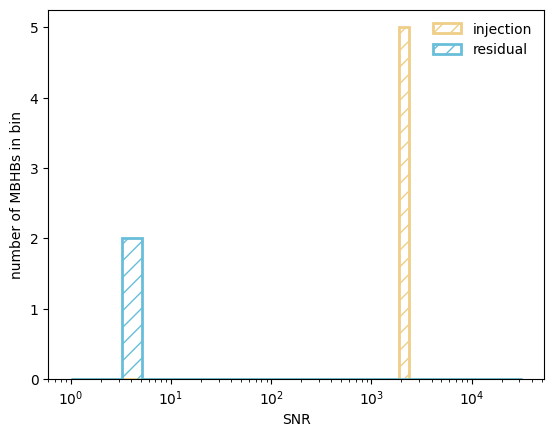

In [ ]:
bins = np.logspace(0, 4.5, 45)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2, label="injection"); 
plt.hist(res_snr_list, bins=bins, density=False, facecolor=None, edgecolor=BLUE, hatch="//", histtype='step', lw=2, label="residual"); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")
plt.legend(loc="upper right", frameon=False)

In [ ]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

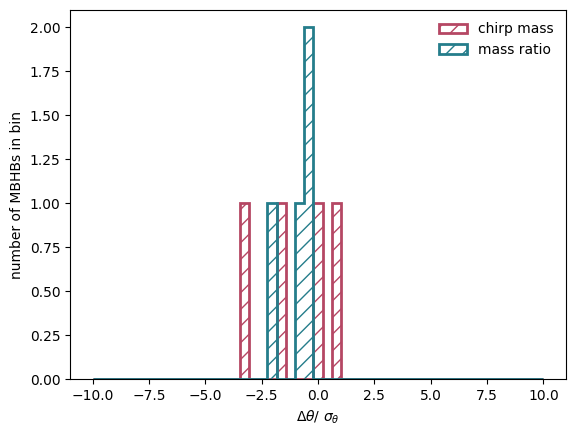

In [ ]:
bins = np.linspace(-10, 10, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

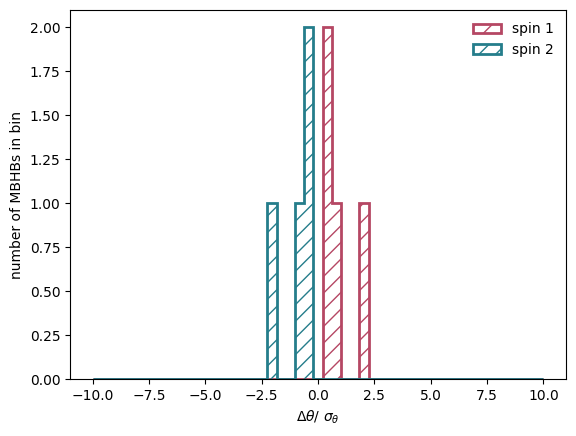

In [ ]:
bins = np.linspace(-10, 10, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

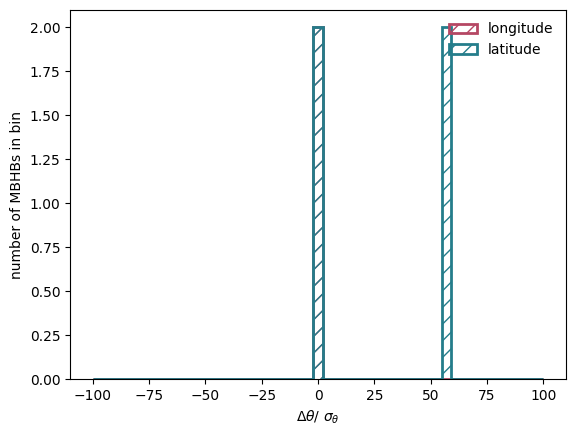

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

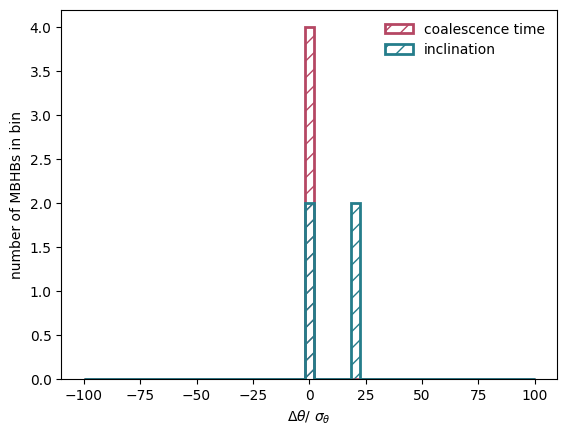

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

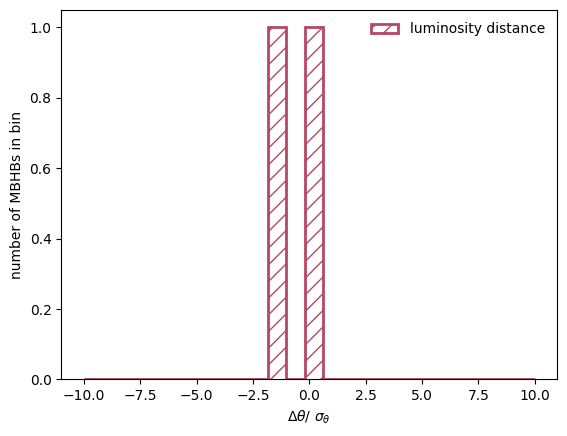

In [ ]:
bins = np.linspace(-10, 10, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
lon_list, lon_list1, lon_list2

(array([5.56733383, 5.56733383, 5.56733383, 5.56733383]),
 array([0.05377418, 0.06339419, 5.5820676 , 5.55195966]),
 array([0.01284622, 0.01284622, 0.01284622, 0.01284622]))

In [ ]:
lat_list, lat_list1, lat_list2

(array([0.50865564, 0.50865564, 0.50865564, 0.50865564]),
 array([1.00751747, 1.03102996, 0.50825782, 0.49817239]),
 array([0.00892593, 0.00892593, 0.00892593, 0.00892593]))

In [ ]:
inc_list, inc_list1, inc_list2

(array([0.74808404, 0.74808404, 0.74808404, 0.74808404]),
 array([2.42036082, 2.29071645, 0.72023419, 0.83803669]),
 array([0.07549262, 0.07549262, 0.07549262, 0.07549262]))